<a href="https://colab.research.google.com/github/Danicoder/Especializacion_IA_BigData/blob/main/RedConvulcioanl_visualizaci%C3%B3nFlores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [258]:
import tensorflow as tf
import keras
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from keras import Sequential
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [259]:
# Descargar y extraer el dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, cache_dir='.', untar=True) #untar=True creó una subcarpeta adicional llamada flower_photos
data_dir = os.path.join(os.path.dirname(data_dir), 'flower_photos')  # Obtener ruta correcta

In [260]:
# Verificar si la carpeta "flower_photos" existe dentro del directorio de datos
flower_photos_dir = os.path.join(data_dir, "flower_photos")

# Actualizar data_dir para que apunte a flower_photos si existe
if os.path.exists(flower_photos_dir):
    data_dir = flower_photos_dir  # Actualizamos a la ruta correcta
    print("Ruta actualizada a:", data_dir)
else:
    print("La carpeta 'flower_photos' no existe en el directorio de datos.")

Ruta actualizada a: ./datasets/flower_photos/flower_photos


In [261]:
# Parámetros del dataset
batch_size = 32
img_height = 180
img_width = 180

# Configurar ImageDataGenerator para cargar imágenes por lotes
# ImageDataGenerator para entrenamiento y validación (con división de 80% y 20%)
train_datagen = ImageDataGenerator(rescale=1.0/255., validation_split=0.2)
# ImageDataGenerator para test (con división de 20%)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training' # División para entrenamiento (80%)
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation' # División para validación (20%)
)
# Para el conjunto de test, no usamos subset ni validation_split
test_generator =  test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
Found 3670 images belonging to 5 classes.


#ENTRENAMIENTO DEL MODELO Y AJUSTE

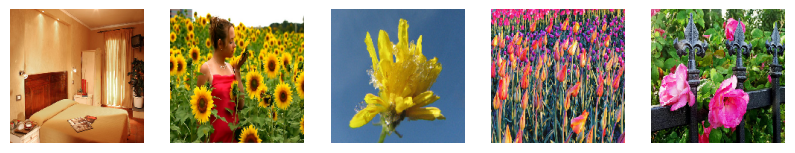

In [262]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener un lote de imágenes del generador
images, labels = next(train_generator)

# Visualizar las primeras 5 imágenes
plt.figure(figsize=(10, 10))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])  # Muestra la imagen
    plt.axis("off")  # No mostrar los ejes
plt.show()


Normalizo los valores para que la red obtenga voleres de entrada pequeños

In [263]:
normalization_layer = layers.Rescaling(1./255)

Data augmentation

In [264]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", # Volteo aleatorio
        input_shape=(img_height,
                     img_width,
                     3)),
    layers.RandomRotation(0.2), # Rotación aleatoria (hasta 288°)
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.5)                   # Ajuste de brillo aleatorio (mas o menos 20%)
  ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Arquitectura del modelo con MobileNetV2

In [265]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights='imagenet')

Capas

Entrenar modelo

In [269]:
model = Sequential()

# Normalización de imágenes
model.add(layers.Rescaling(1./255))

# Capa Convolucional 1
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())

# Capa Convolucional 2
model.add(Conv2D(32, (3, 3),  padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Capa Convolucional 3
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

# evito sobreajuste
model.add(Dropout(0.2))
# Aplanar las características
model.add(Flatten())

# Capa densa con 128 neuronas
model.add(Dense(128, activation='relu'))
# Capa de salida con 5 neuronas
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_15 (Rescaling)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Compilar modelo

In [270]:
model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [271]:
history = model.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator,
      verbose=1,
      callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6),
        tf.keras.callbacks.ModelCheckpoint(filepath='modelo_flowers.h5', monitor='val_loss', save_best_only=True)
      ]
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.2318 - loss: 1.6057

92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - accuracy: 0.2319 - loss: 1.6057 - val_accuracy: 0.2736 - val_loss: 1.5993 - learning_rate: 1.0000e-04
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2481 - loss: 1.5960

92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.2482 - loss: 1.5960 - val_accuracy: 0.2544 - val_loss: 1.5803 - learning_rate: 1.0000e-04
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2786 - loss: 1.5683

92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.2789 - loss: 1.5680 - val_accuracy: 0.2996 - val_loss: 1.5136 - learning_rate: 1.0000e-04
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3276 - loss: 1.4789

92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.3277 - loss: 1.4787 - val_accuracy: 0.3420 - val_loss: 1.4635 - learning_rate: 1.0000e-04
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3585 - loss: 1.4295

92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.3586 - loss: 1.4294 - val_accuracy: 0.3926 - val_loss: 1.4114 - learning_rate: 1.0000e-04
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.3781 - loss: 1.3949 - val_accuracy: 0.3707 - val_loss: 1.4212 - learning_rate: 1.0000e-04
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3875 - loss: 1.3844

92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.3876 - loss: 1.3843 - val_accuracy: 0.4200 - val_loss: 1.3473 - learning_rate: 1.0000e-04
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4164 - loss: 1.3387

92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.4166 - loss: 1.3386 - val_accuracy: 0.4391 - val_loss: 1.3089 - learning_rate: 1.0000e-04
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4500 - loss: 1.2732

92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.4500 - loss: 1.2734 - val_accuracy: 0.4364 - val_loss: 1.2729 - learning_rate: 1.0000e-04
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.4891 - loss: 1.2372 - val_accuracy: 0.4254 - val_loss: 1.2886 - learning_rate: 1.0000e-04


Evaluo el modelo

In [274]:
test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse'  # Change class_mode to 'sparse'
)


Found 3670 images belonging to 5 classes.


Visualizar las Curvas de accuracy y val_accuracy

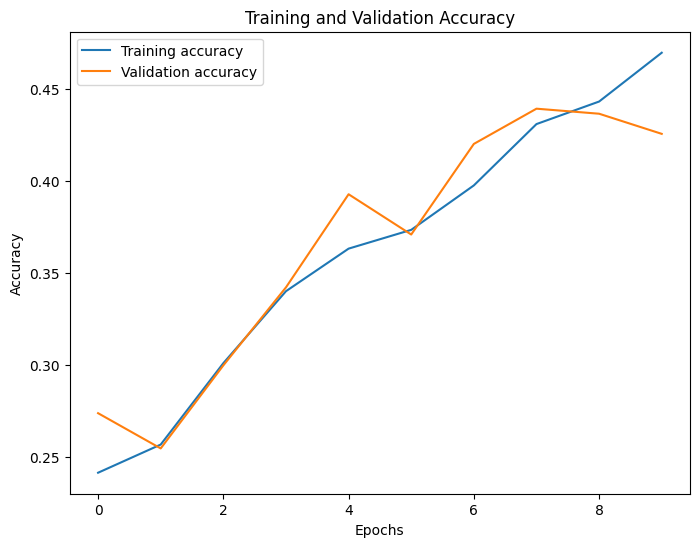

In [275]:
# Graficar la precisión y la precisión de validación
plt.figure(figsize=(8, 6))

# Accuracy de entrenamiento
plt.plot(history.history['accuracy'], label='Training accuracy')

# Accuracy de validación
plt.plot(history.history['val_accuracy'], label='Validation accuracy')

# Añadir etiquetas
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Mostrar la gráfica
plt.show()

Transfer Learning (Aumenta la presición del la red)

In [276]:
vgg16_conv_base = VGG16(
    input_shape = (
        img_height,img_width,3),  # Tamaño de la imágen de entrada con 180 canales * 3 (rojo,verde y azul)
        include_top=False,        # excluye la capa final
        weights = 'imagenet')     # conjunto de datos

vgg16_conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Fine-Tuning: Descongelar Capas del Modelo Base

In [277]:
vgg16_conv_base.trainable = True

# Define TrainingConfig as a simple class to hold configuration
class TrainingConfig:
    LAYERS_FINE_TUNE = 8

num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(vgg16_conv_base.layers)

# Congelamos las capas que no vamos a entrenar
for layer in vgg16_conv_base.layers[:num_layers - num_layers_fine_tune]:
    print(f"FREEZING LAYER: {layer}")
    layer.trainable = False

print("\n")
print(f"Configured to fine tune the last {num_layers_fine_tune} layers of the base model.")
print("\n")

# Verificamos el estado de las capas
print(vgg16_conv_base.summary())



FREEZING LAYER: <InputLayer name=input_layer_45, built=True>
FREEZING LAYER: <Conv2D name=block1_conv1, built=True>
FREEZING LAYER: <Conv2D name=block1_conv2, built=True>
FREEZING LAYER: <MaxPooling2D name=block1_pool, built=True>
FREEZING LAYER: <Conv2D name=block2_conv1, built=True>
FREEZING LAYER: <Conv2D name=block2_conv2, built=True>
FREEZING LAYER: <MaxPooling2D name=block2_pool, built=True>
FREEZING LAYER: <Conv2D name=block3_conv1, built=True>
FREEZING LAYER: <Conv2D name=block3_conv2, built=True>
FREEZING LAYER: <Conv2D name=block3_conv3, built=True>
FREEZING LAYER: <MaxPooling2D name=block3_pool, built=True>


Configured to fine tune the last 8 layers of the base model.




Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 12,979,200 (49.51 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

None
